In [1]:
import os
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import string
import h5py
from tqdm import tqdm

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from accelerate import Accelerator, DeepSpeedPlugin

# SDXL unCLIP requires code from https://github.com/Stability-AI/generative-models/tree/main
sys.path.append('generative_models/')
import sgm
from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder, FrozenCLIPEmbedder, FrozenOpenCLIPEmbedder2
from generative_models.sgm.models.diffusion import DiffusionEngine
from generative_models.sgm.util import append_dims
from omegaconf import OmegaConf

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
import utils
from models import *

accelerator = Accelerator(split_batches=False, mixed_precision="fp16")
device = accelerator.device
print("device:",device)

/home/users/ywei13/.conda/envs/playground/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/home/users/ywei13/.conda/envs/playground/lib/python3.11/site-packages/rotary_embedding_torch/rotary_embedding_torch.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)
/home/users/ywei13/.conda/envs/playground/lib/python3.11/site-packages/rotary_embedding_torch/rotary_embedding_torch.py:258: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)


device: cuda


In [2]:
# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    model_name = "final_subj01_pretrained_40sess_24bs"
    print("model_name:", model_name)

    # global_batch_size and batch_size should already be defined in the above cells
    # other variables can be specified in the following string:
    jupyter_args = f"--model_name={model_name} --subj=1"
    print(jupyter_args)
    jupyter_args = jupyter_args.split()
    
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

model_name: final_subj01_pretrained_40sess_24bs
--model_name=final_subj01_pretrained_40sess_24bs --subj=1


In [3]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str, default="testing",
    help="will load ckpt for model found in ../train_logs/model_name",
)
parser.add_argument(
    "--subj",type=int, default=1, choices=[1,2,3,4,5,6,7,8],
    help="Evaluate on which subject?",
)
parser.add_argument(
    "--seed",type=int,default=42,
)
if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)
    
# seed all random functions
utils.seed_everything(seed)

# make output directory
os.makedirs("evals",exist_ok=True)
os.makedirs(f"evals/{model_name}",exist_ok=True)

# Some of these files are downloadable from huggingface: https://huggingface.co/datasets/pscotti/mindeyev2/tree/main/evals
# The others are obtained from running recon_inference.ipynb first with your desired model
all_images = torch.load(f"evals/all_images.pt")
all_recons = torch.load(f"evals/{model_name}/{model_name}_all_recons.pt") # these are the unrefined MindEye2 recons!
all_clipvoxels = torch.load(f"evals/{model_name}/{model_name}_all_clipvoxels.pt")
all_blurryrecons = torch.load(f"evals/{model_name}/{model_name}_all_blurryrecons.pt")
all_predcaptions = torch.load(f"evals/{model_name}/{model_name}_all_predcaptions.pt")

all_recons = transforms.Resize((768,768))(all_recons).float()
all_blurryrecons = transforms.Resize((768,768))(all_blurryrecons).float()

print(model_name)
print(all_images.shape, all_recons.shape, all_clipvoxels.shape, all_blurryrecons.shape, all_predcaptions.shape)

/tmp/ipykernel_1505064/586937649.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_images = torch.load(f"evals/all_images.pt")
/tmp/ipykernel_1505064/586937649.py:32:

final_subj01_pretrained_40sess_24bs
torch.Size([1000, 3, 224, 224]) torch.Size([1000, 3, 768, 768]) torch.Size([1000, 256, 1664]) torch.Size([1000, 3, 768, 768]) (1000,)


In [ ]:
config = OmegaConf.load("generative_models/configs/unclip6.yaml")
config = OmegaConf.to_container(config, resolve=True)
unclip_params = config["model"]["params"]
sampler_config = unclip_params["sampler_config"]
sampler_config['params']['num_steps'] = 38
config = OmegaConf.load("generative_models/configs/inference/sd_xl_base.yaml")
config = OmegaConf.to_container(config, resolve=True)
refiner_params = config["model"]["params"]

network_config = refiner_params["network_config"]
denoiser_config = refiner_params["denoiser_config"]
first_stage_config = refiner_params["first_stage_config"]
conditioner_config = refiner_params["conditioner_config"]
scale_factor = refiner_params["scale_factor"]
disable_first_stage_autocast = refiner_params["disable_first_stage_autocast"]

# base_ckpt_path = '/weka/robin/projects/stable-research/checkpoints/sd_xl_base_1.0.safetensors'
base_ckpt_path = '/home/users/ywei13/playground/BrainGen/data/NSD/zavychromaxl_v30.safetensors'
base_engine = DiffusionEngine(network_config=network_config,
                       denoiser_config=denoiser_config,
                       first_stage_config=first_stage_config,
                       conditioner_config=conditioner_config,
                       sampler_config=sampler_config, # using the one defined by the unclip
                       scale_factor=scale_factor,
                       disable_first_stage_autocast=disable_first_stage_autocast,
                       ckpt_path=base_ckpt_path)
base_engine.eval().requires_grad_(False)
base_engine.to(device)

base_text_embedder1 = FrozenCLIPEmbedder(
    layer=conditioner_config['params']['emb_models'][0]['params']['layer'],
    layer_idx=conditioner_config['params']['emb_models'][0]['params']['layer_idx'],
)
base_text_embedder1.to(device)

base_text_embedder2 = FrozenOpenCLIPEmbedder2(
    arch=conditioner_config['params']['emb_models'][1]['params']['arch'],
    version=conditioner_config['params']['emb_models'][1]['params']['version'],
    freeze=conditioner_config['params']['emb_models'][1]['params']['freeze'],
    layer=conditioner_config['params']['emb_models'][1]['params']['layer'],
    always_return_pooled=conditioner_config['params']['emb_models'][1]['params']['always_return_pooled'],
    legacy=conditioner_config['params']['emb_models'][1]['params']['legacy'],
)
base_text_embedder2.to(device)

batch={"txt": "",
      "original_size_as_tuple": torch.ones(1, 2).to(device) * 768,
      "crop_coords_top_left": torch.zeros(1, 2).to(device),
      "target_size_as_tuple": torch.ones(1, 2).to(device) * 1024}
out = base_engine.conditioner(batch)
crossattn = out["crossattn"].to(device)
vector_suffix = out["vector"][:,-1536:].to(device)
print("crossattn", crossattn.shape)
print("vector_suffix", vector_suffix.shape)
print("---")

batch_uc={"txt": "painting, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, deformed, ugly, blurry, bad anatomy, bad proportions, extra limbs, cloned face, skinny, glitchy, double torso, extra arms, extra hands, mangled fingers, missing lips, ugly face, distorted face, extra legs, anime",
      "original_size_as_tuple": torch.ones(1, 2).to(device) * 768,
      "crop_coords_top_left": torch.zeros(1, 2).to(device),
      "target_size_as_tuple": torch.ones(1, 2).to(device) * 1024}
out = base_engine.conditioner(batch_uc)
crossattn_uc = out["crossattn"].to(device)
vector_uc = out["vector"].to(device)
print("crossattn_uc", crossattn_uc.shape)
print("vector_uc", vector_uc.shape)

In [11]:
if utils.is_interactive(): plotting=True

num_samples = 1 # PS: I tried increasing this to 16 and picking highest cosine similarity like we did in MindEye1, it didnt seem to increase eval performance!
img2img_timepoint = 13 # 9 # higher number means more reliance on prompt, less reliance on matching the conditioning image
base_engine.sampler.guider.scale = 5 # 5 # cfg
def denoiser(x, sigma, c): return base_engine.denoiser(base_engine.model, x, sigma, c)

if plotting or num_samples>1:
    clip_img_embedder = FrozenOpenCLIPImageEmbedder(
        arch="ViT-bigG-14",
        version="laion2b_s39b_b160k",
        output_tokens=True,
        only_tokens=True,
    )
    clip_img_embedder.to(device)

INFO:root:Loaded ViT-bigG-14 model config.
INFO:root:Loading pretrained ViT-bigG-14 weights (laion2b_s39b_b160k).
/home/users/ywei13/.conda/envs/playground/lib/python3.11/site-packages/open_clip/factory.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Pl

  0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_1505064/2934457488.py:3: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16), base_engine.ema_scope():


blur pixcorr: tensor(0.3743)


/home/users/ywei13/playground/BrainGen/MindEyeV2/src/generative_models/sgm/util.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(
/home/users/ywei13/playground/BrainGen/MindEyeV2/src/generative_models/sgm/util.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(


blur cossim: tensor([0.2365], device='cuda:0')
recon pixcorr: tensor(0.1905)


/home/users/ywei13/playground/BrainGen/MindEyeV2/src/generative_models/sgm/util.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(
/home/users/ywei13/playground/BrainGen/MindEyeV2/src/generative_models/sgm/util.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(


recon cossim: tensor([0.3021], device='cuda:0')
prompt: a group of people standing around a table.


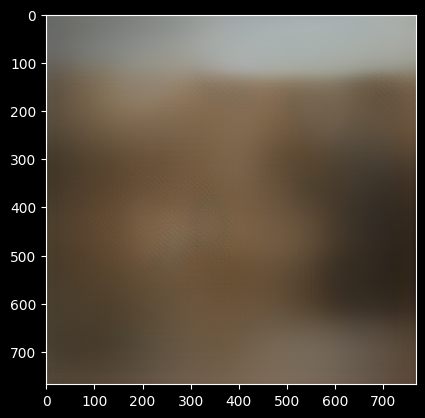

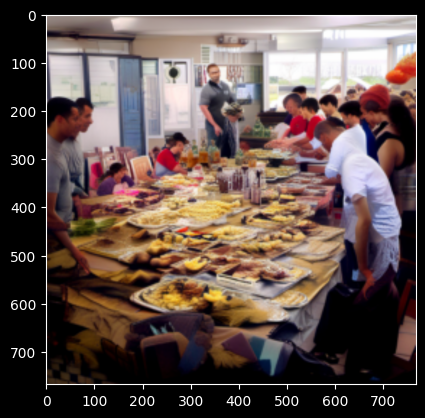

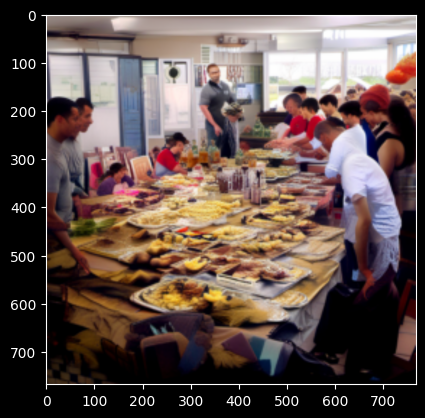

/home/users/ywei13/playground/BrainGen/MindEyeV2/src/generative_models/sgm/util.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(
/home/users/ywei13/playground/BrainGen/MindEyeV2/src/generative_models/sgm/util.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(
/home/users/ywei13/.conda/envs/playground/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/users/

samples torch.Size([1, 3, 768, 768])


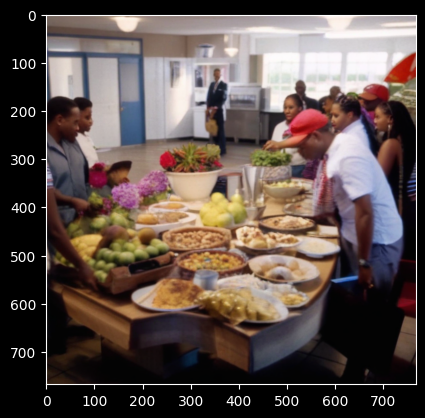

CHOSEN ABOVE
upsampled pixcorr: tensor(0.1830)


/home/users/ywei13/playground/BrainGen/MindEyeV2/src/generative_models/sgm/util.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(
  0%|          | 0/1000 [21:40<?, ?it/s]


upsampled cossim: tensor([0.3119], device='cuda:0')


NameError: name 'err' is not defined

In [12]:
all_enhancedrecons = None
for img_idx in tqdm(range(len(all_recons))):
    with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16), base_engine.ema_scope():
        base_engine.sampler.num_steps = 25
        
        image = all_recons[[img_idx]]
        
        if plotting:
            print("blur pixcorr:",utils.pixcorr(all_blurryrecons[[img_idx]].float(), all_images[[img_idx]].float()))
            print("blur cossim:",nn.functional.cosine_similarity(clip_img_embedder(utils.resize(all_blurryrecons[[img_idx]].float(),256).to(device)).flatten(1), 
                                                         clip_img_embedder(utils.resize(all_images[[img_idx]].float(),224).to(device)).flatten(1)))

            print("recon pixcorr:",utils.pixcorr(image,all_images[[img_idx]].float()))
            print("recon cossim:",nn.functional.cosine_similarity(clip_img_embedder(utils.resize(image,224).to(device)).flatten(1), 
                                                         clip_img_embedder(utils.resize(all_images[[img_idx]].float(),224).to(device)).flatten(1)))
        
        image = image.to(device)
        prompt = all_predcaptions[[img_idx]][0]
        # prompt = ""
        if plotting: 
            print("prompt:",prompt)
            plt.imshow(transforms.ToPILImage()(all_blurryrecons[img_idx].float()))
            plt.show()
            plt.imshow(transforms.ToPILImage()(all_recons[img_idx].float()))
            plt.show()
            plt.imshow(transforms.ToPILImage()(image[0]))
            plt.show()

        # z = torch.randn(num_samples,4,96,96).to(device)
        assert image.shape[-1]==768
        z = base_engine.encode_first_stage(image*2-1).repeat(num_samples,1,1,1)

        openai_clip_text = base_text_embedder1(prompt)
        clip_text_tokenized, clip_text_emb  = base_text_embedder2(prompt)
        clip_text_emb = torch.hstack((clip_text_emb, vector_suffix))
        clip_text_tokenized = torch.cat((openai_clip_text, clip_text_tokenized),dim=-1)
        c = {"crossattn": clip_text_tokenized.repeat(num_samples,1,1), "vector": clip_text_emb.repeat(num_samples,1)}
        uc = {"crossattn": crossattn_uc.repeat(num_samples,1,1), "vector": vector_uc.repeat(num_samples,1)}

        noise = torch.randn_like(z)
        sigmas = base_engine.sampler.discretization(base_engine.sampler.num_steps).to(device)
        init_z = (z + noise * append_dims(sigmas[-img2img_timepoint], z.ndim)) / torch.sqrt(1.0 + sigmas[0] ** 2.0)
        sigmas = sigmas[-img2img_timepoint:].repeat(num_samples,1)

        base_engine.sampler.num_steps = sigmas.shape[-1] - 1
        noised_z, _, _, _, c, uc = base_engine.sampler.prepare_sampling_loop(init_z, cond=c, uc=uc, 
                                                            num_steps=base_engine.sampler.num_steps)
        for timestep in range(base_engine.sampler.num_steps):
            noised_z = base_engine.sampler.sampler_step(sigmas[:,timestep],
                                                        sigmas[:,timestep+1],
                                                        denoiser, noised_z, cond=c, uc=uc, gamma=0)
        samples_z_base = noised_z
        samples_x = base_engine.decode_first_stage(samples_z_base)
        samples = torch.clamp((samples_x + 1.0) / 2.0, min=0.0, max=1.0)

        # find best sample
        if plotting==False and num_samples==1:
            samples = samples[0]
        else:
            sample_cossim = nn.functional.cosine_similarity(clip_img_embedder(utils.resize(samples,224).to(device)).flatten(1), 
                                clip_img_embedder(utils.resize(all_images[[img_idx]].float(),224).to(device)).flatten(1))
            which_sample = torch.argmax(sample_cossim)
            best_cossim = torch.max(sample_cossim)

            if plotting:
                print("samples", samples.shape)
                for n in range(num_samples):
                    recon = transforms.ToPILImage()(samples[n])
                    plt.imshow(recon)
                    plt.show()
                    if (n==which_sample).item(): print("CHOSEN ABOVE")
                    print("upsampled pixcorr:",utils.pixcorr(samples[[n]].cpu(),all_images[[img_idx]].float()))
                    print("upsampled cossim:",nn.functional.cosine_similarity(clip_img_embedder(utils.resize(samples[[n]],224).to(device)).flatten(1), 
                                                         clip_img_embedder(utils.resize(all_images[[img_idx]].float(),224).to(device)).flatten(1)))
                err # dont want to do entire for loop with plotting=True

            samples = samples[which_sample]

        samples = samples.cpu()[None]
        if all_enhancedrecons is None:
            all_enhancedrecons = samples
        else:
            all_enhancedrecons = torch.vstack((all_enhancedrecons, samples))
            
all_enhancedrecons = transforms.Resize((256,256))(all_enhancedrecons).float()
print("all_enhancedrecons", all_enhancedrecons.shape)
torch.save(all_enhancedrecons,f"evals/{model_name}/{model_name}_all_enhancedrecons.pt")
print(f"saved evals/{model_name}/{model_name}_all_enhancedrecons.pt")

if not utils.is_interactive():
    sys.exit(0)